Author: Vince Lai 

# CS171 Final Project - Data Processing Notebook

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_csv('AirQuality.csv', sep=";", decimal=",")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [25]:
# Clean dataset 
df = df.loc[:, ~df.columns.str.contains('Unnamed')]
df = df.replace(-200, np.nan)
df.isna().sum()

Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
dtype: int64

In [26]:
# Convert Date & Time 
df['Datetime'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'], 
    format="%d/%m/%Y %H.%M.%S"
)

df = df.drop(columns=['Date','Time'])
df = df.sort_values('Datetime').reset_index(drop=True)
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00


In [27]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    missing_pct = df[col].isna().sum() / len(df)
    if missing_pct > 0.5:
        print("Dropping:", col)
        df = df.drop(columns=[col])
    else:
        df[col] = df[col].fillna(df[col].median())

Dropping: NMHC(GT)


In [28]:
# Featuring 
df['hour'] = df['Datetime'].dt.hour
df['day_of_week'] = df['Datetime'].dt.dayofweek
df['month'] = df['Datetime'].dt.month

In [30]:
# Compute AQI
pollutant_cols = [
    'NO2(GT)', 'NOx(GT)', 'C6H6(GT)',
    'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
    'PT08.S4(NO2)', 'PT08.S5(O3)'
]

available_pollutants = [c for c in pollutant_cols if c in df.columns]

df['AQI'] = df[available_pollutants].mean(axis=1)

In [31]:
# 1-hour-ahead target
df['AQI_next_hour'] = df['AQI'].shift(-1)
df_clean = df.dropna().copy()

print("Final cleaned shape:", df_clean.shape)
df_clean.head()

Final cleaned shape: (9357, 18)


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime,hour,day_of_week,month,AQI,AQI_next_hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18.0,2.0,3.0,839.1125,769.5500
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19.0,2.0,3.0,769.5500,795.5000
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20.0,2.0,3.0,795.5000,813.2750
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21.0,2.0,3.0,813.2750,770.8125
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22.0,2.0,3.0,770.8125,726.9625


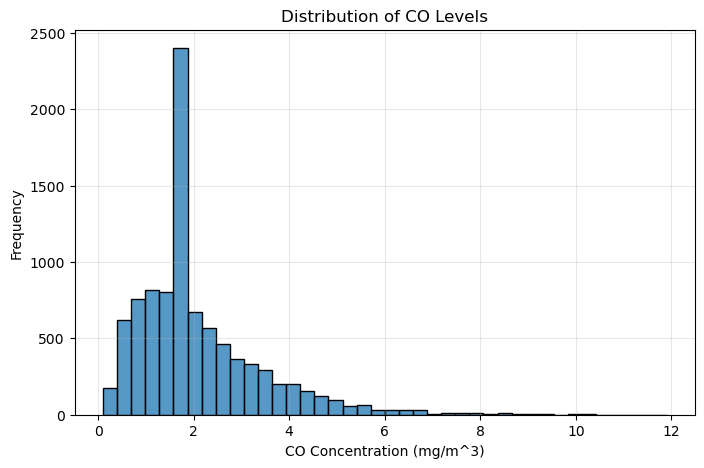

In [32]:
# make a plot 
plt.figure(figsize=(8,5))
sns.histplot(df_clean["CO(GT)"], bins=40)
plt.title("Distribution of CO Levels")
plt.xlabel("CO Concentration (mg/m^3)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [33]:
df_clean.to_csv("vince_clean_airquality.csv", index=False)